In [1]:
import pandas as pd
import numpy as np
from itertools import combinations
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from parameters import *
from functions import *

Reading the data

In [2]:
df = get_normalized_stats()
df_bios_contracts = get_bio_contracts()
df_contracts_last_season = get_contracts_last_season()
df_bios_contracts['2023-24 Salary'] = df_bios_contracts['2023-24 Salary'].dropna().apply(convert_number).fillna(0)
df_bios_contracts['Age'] = df_bios_contracts['Date Born'].apply(calculate_age)
df_bios_contracts['Pos'] = df_bios_contracts['Position'].apply(map_position)
df_bios_contracts = df_bios_contracts.merge(df_contracts_last_season[['Player','2022-23']], left_on='Player', right_on='Player', suffixes=('', '_base'), how='left')

Similarity Score and Stronger Stats

In [3]:
df = df[columns_streamlit]


result_df = pd.DataFrame(index=df.index, columns=[3, 5, 7, 10])

# Get the 'n' variables with the highest z-value for each player and store them in the results dataframe.
for n in [3, 5, 7, 10]:
    result_df[n] = df.apply(lambda row: top_n_stats(row, n), axis=1)


results = []

# Calculate the cosine similarity
cosine_sim_matrix = cosine_similarity(df)


# Calculate the coincidences and cosine similarity for each pair of players.
for i in result_df.index:
    for j in result_df.index:
        if i != j:
            i_index = df.index.get_loc(i)
            j_index = df.index.get_loc(j)
            result_row = {
                'Player 1': i,
                'Player 2': j,
                'Top 3 Coincidencies': count_common_elements(result_df.at[i, 3], result_df.at[j, 3]),
                'Top 3 Player 1': result_df.at[i, 3],
                'Top 3 Player 2': result_df.at[j, 3],
                'Top 5 Coincidencies': count_common_elements(result_df.at[i, 5], result_df.at[j, 5]),
                'Top 5 Player 1': result_df.at[i, 5],
                'Top 5 Player 2': result_df.at[j, 5],
                'Top 7 Coincidencies': count_common_elements(result_df.at[i, 7], result_df.at[j, 7]),
                'Top 7 Player 1': result_df.at[i, 7],
                'Top 7 Player 2': result_df.at[j, 7],
                'Top 10 Coincidencies': count_common_elements(result_df.at[i, 10], result_df.at[j, 10]),
                'Top 10 Player 1': result_df.at[i, 10],
                'Top 10 Player 2': result_df.at[j, 10],
                'Cosine Similarity': cosine_sim_matrix[i_index, j_index]
            }
            results.append(result_row)

# Convert the list of results into a dataframe
staging_df = pd.DataFrame(results)
staging_df['Cosine Similarity'] = round(staging_df['Cosine Similarity'],2)



Adding Age, Position and Contract Information

In [4]:
staging_df = staging_df.merge(df_bios_contracts[['Player','Age', '2022-23', 'Pos']], left_on='Player 1', right_on='Player', suffixes=('', '_base'))
staging_df = staging_df.merge(df_bios_contracts[['Player','Age', '2022-23', 'Pos']], left_on='Player 2', right_on='Player', suffixes=('', '_compared'))

In [5]:
save_model_data(staging_df, 'Staging Similarities.xlsx', path_model_data)

Data saved in data/4_model/Staging Similarities.xlsx


Aggregating and consolidating Similarities

In [6]:
df = pd.read_excel(path_model_data + '/Staging Similarities.xlsx')

In [7]:
df['Absolute Age Difference'] = abs(df['Age'] - df['Age_compared'])
df['Absolute Salary Difference'] = abs(df['2022-23'] - df['2022-23_compared'])
df['Pos Check'] = df.apply(check_partial_containment, axis=1)
df['Salary Flag'] = df.apply(check_salary_difference, axis=1)
df['Age Flag'] = df.apply(check_age_difference, axis=1)
df['Free Agent Flag'] = df.apply(check_salary, axis=1)

df['Top 3 Flag'] = df.apply(top3_flag, axis=1)
df['Top 5 Flag'] = df.apply(top5_flag, axis=1)
df['Top 7 Flag'] = df.apply(top7_flag, axis=1)
df['Top 10 Flag'] = df.apply(top10_flag, axis=1)

df['Count'] = 1

df = df[['Player 1', 'Player 2', 'Top 3 Coincidencies', 'Top 3 Flag', 'Top 5 Coincidencies', 'Top 5 Flag','Top 7 Coincidencies', 'Top 7 Flag','Top 10 Coincidencies', 'Top 10 Flag', 'Cosine Similarity', 'Absolute Age Difference', 'Absolute Salary Difference', 'Pos Check', 'Free Agent Flag', 'Salary Flag','Age Flag', 'Count']]

In [8]:
save_model_data(df, 'Enriched Similarities.xlsx', path_model_data)

Data saved in data/4_model/Enriched Similarities.xlsx


Metrics by Cosine Similarity and Player

In [29]:
df = pd.read_excel(path_model_data + '/Enriched Similarities.xlsx')

In [30]:
grouped = df.groupby(['Player 1', 'Cosine Similarity']).agg(
    Count_of_Similarities=('Count', 'sum'),
    Top_3_Flag_Sum=('Top 3 Flag', 'sum'),
    Top_5_Flag_Sum=('Top 5 Flag', 'sum'),
    Top_7_Flag_Sum=('Top 7 Flag', 'sum'),
    Top_10_Flag_Sum=('Top 10 Flag', 'sum'),
    Age_Flag=('Age Flag', 'sum'),
    Salary_Flag=('Salary Flag', 'sum')
)


final_df = grouped[['Count_of_Similarities', 'Top_3_Flag_Sum', 'Top_5_Flag_Sum', 'Top_7_Flag_Sum', 'Top_10_Flag_Sum','Age_Flag', 'Salary_Flag']].reset_index()

final_df = final_df.fillna(0)

final_df = final_df.sort_values(by=['Player 1','Cosine Similarity'], ascending=False)

In [31]:
final_df["Cumulative_Count_of_Similarities"] = final_df.groupby("Player 1")["Count_of_Similarities"].cumsum()
final_df["Cumulative_Top_3_Coincidencies_Sum"] = final_df.groupby("Player 1")["Top_3_Flag_Sum"].cumsum()
final_df["Cumulative_Top_5_Coincidencies_Sum"] = final_df.groupby("Player 1")["Top_5_Flag_Sum"].cumsum()
final_df["Cumulative_Top_7_Coincidencies_Sum"] = final_df.groupby("Player 1")["Top_7_Flag_Sum"].cumsum()
final_df["Cumulative_Top_10_Coincidencies_Sum"] = final_df.groupby("Player 1")["Top_10_Flag_Sum"].cumsum()
final_df["Cumulative_Age_Flag"] = final_df.groupby("Player 1")["Age_Flag"].cumsum()
final_df["Cumulative_Salary_Flag"] = final_df.groupby("Player 1")["Salary_Flag"].cumsum()


final_df['Top 3 %'] = round(final_df['Cumulative_Top_3_Coincidencies_Sum'] / (final_df['Cumulative_Count_of_Similarities'] ),4)
final_df['Top 5 %'] = round(final_df['Cumulative_Top_5_Coincidencies_Sum'] / (final_df['Cumulative_Count_of_Similarities'] ),4)
final_df['Top 7 %'] = round(final_df['Cumulative_Top_7_Coincidencies_Sum'] / (final_df['Cumulative_Count_of_Similarities'] ),4)
final_df['Top 10 %'] = round(final_df['Cumulative_Top_10_Coincidencies_Sum'] / (final_df['Cumulative_Count_of_Similarities']),4)
final_df['Age %'] = round(final_df['Cumulative_Age_Flag'] / final_df['Cumulative_Count_of_Similarities'],4)
final_df['Salary %'] = round(final_df['Cumulative_Salary_Flag'] / final_df['Cumulative_Count_of_Similarities'],4)

final_df = final_df[['Player 1', 'Cosine Similarity','Cumulative_Count_of_Similarities', 'Top 3 %', 'Top 5 %', 'Top 7 %', 'Top 10 %', 'Age %', 'Salary %']]


In [32]:
save_model_data(final_df, 'Final by Player Similarities.xlsx', path_model_data)

Data saved in data/4_model/Final by Player Similarities.xlsx


Metrics by Cosine Similarity

In [33]:
grouped = final_df.groupby(['Cosine Similarity']).agg(
    Count_of_Similarities=('Cumulative_Count_of_Similarities', 'mean'),
    Std_of_Similarities=('Cumulative_Count_of_Similarities', 'std'),
    Top_3=('Top 3 %', 'mean'),
    Top_5=('Top 5 %', 'mean'),
    Top_7=('Top 7 %', 'mean'),
    Top_10=('Top 10 %', 'mean'),
    Age=('Age %', 'mean'),
    Salary=('Salary %', 'mean')
)

final_df_sim = grouped[['Count_of_Similarities','Std_of_Similarities', 'Top_3', 'Top_5', 'Top_7', 'Top_10','Age', 'Salary']].reset_index()

final_df_sim = final_df_sim.fillna(0)

final_df_sim = final_df_sim.sort_values(by=['Cosine Similarity'], ascending=False)

In [34]:
save_model_data(final_df_sim, 'Final Similarities.xlsx', path_model_data)

Data saved in data/4_model/Final Similarities.xlsx


Plotting Results

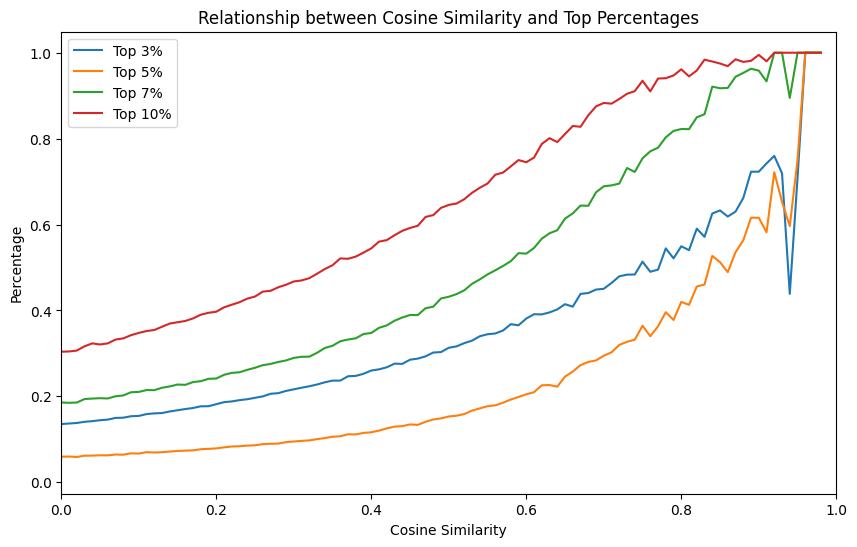

In [35]:
# Extract the relevant columns from the data
cosine_similarity = [float(x) for x in final_df_sim['Cosine Similarity']]
top3_percent = [float(x) for x in final_df_sim['Top_3']]
top5_percent = [float(x) for x in final_df_sim['Top_5']]
top7_percent = [float(x) for x in final_df_sim['Top_7']]
top10_percent = [float(x) for x in final_df_sim['Top_10']]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(cosine_similarity, top3_percent, label='Top 3%')
plt.plot(cosine_similarity, top5_percent, label='Top 5%')
plt.plot(cosine_similarity, top7_percent, label='Top 7%')
plt.plot(cosine_similarity, top10_percent, label='Top 10%')

# Add labels and title
plt.xlabel('Cosine Similarity')
plt.ylabel('Percentage')
plt.title('Relationship between Cosine Similarity and Top Percentages')
plt.legend()

plt.xlim(0, 1)
# Show the plot
plt.show()

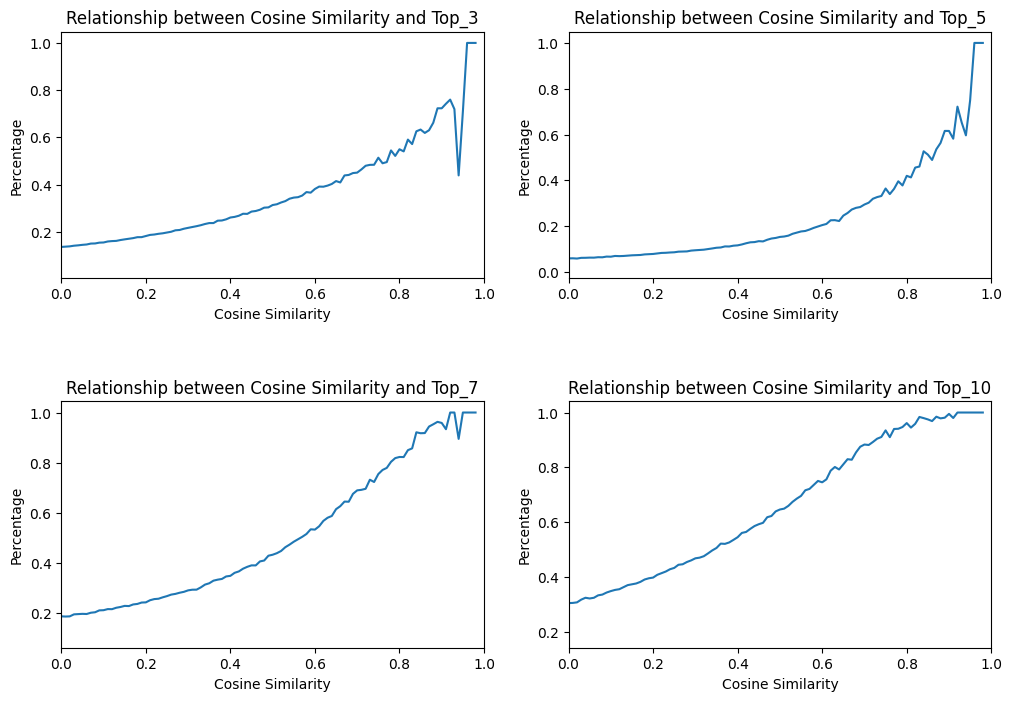

In [36]:
# Create a figure with 4 subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.flatten()

# Iterate over the axes and plot each top percentage separately
for i, top_col in enumerate(['Top_3', 'Top_5', 'Top_7', 'Top_10']):
    ax = axes[i]
    ax.plot(final_df_sim['Cosine Similarity'], final_df_sim[top_col])
    ax.set_xlabel('Cosine Similarity')
    ax.set_ylabel('Percentage')
    ax.set_title(f'Relationship between Cosine Similarity and {top_col}')
    ax.set_xlim(0, 1)

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.5)

# Show the plot
plt.show()

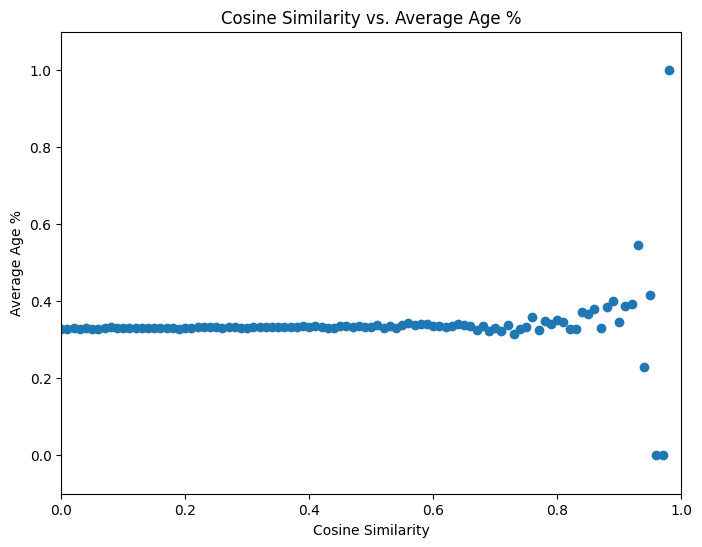

In [37]:
# Create a figure and an axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot cosine similarity vs. position percentage
ax.scatter(final_df_sim['Cosine Similarity'], final_df_sim['Age'])
ax.set_xlabel('Cosine Similarity')
ax.set_ylabel('Average Age %')
ax.set_title('Cosine Similarity vs. Average Age %')

# Adjust the y-axis limits for better visualization.
ax.set_ylim(-0.1, 1.1)
plt.xlim(0, 1)
# Show the graph
plt.show()

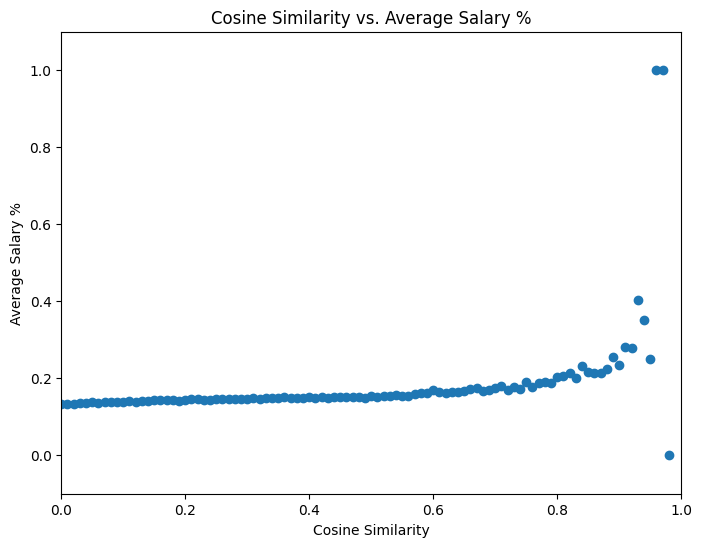

In [38]:
# Create a figure and an axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot cosine similarity vs. position percentage
ax.scatter(final_df_sim['Cosine Similarity'], final_df_sim['Salary'])
ax.set_xlabel('Cosine Similarity')
ax.set_ylabel('Average Salary %')
ax.set_title('Cosine Similarity vs. Average Salary %')

# Adjust the y-axis limits for better visualization.
ax.set_ylim(-0.1, 1.1)
plt.xlim(0, 1)
# Show the graph
plt.show()

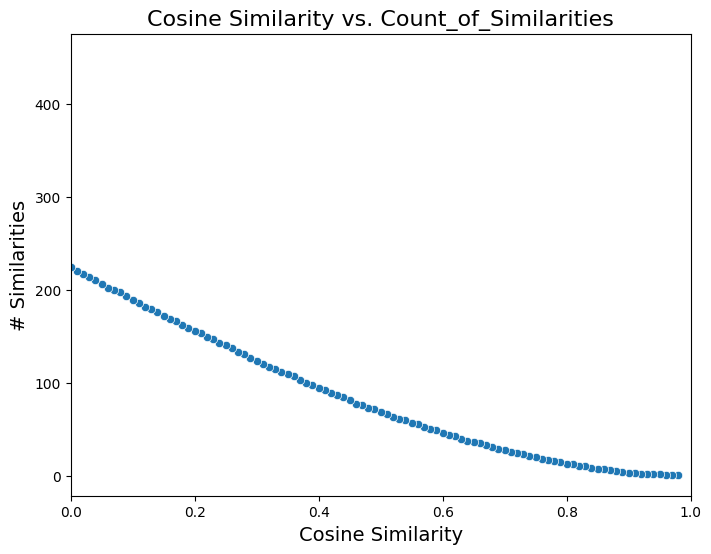

In [39]:
# Create a figure and an axis
fig, ax = plt.subplots(figsize=(8, 6))

# Scatter Plot
sns.scatterplot(y='Count_of_Similarities', x='Cosine Similarity', data=final_df_sim)


# Set up labels and title
ax.set_xlabel('Cosine Similarity', fontsize=14)
ax.set_ylabel('# Similarities', fontsize=14)
ax.set_title('Cosine Similarity vs. Count_of_Similarities', fontsize=16)

plt.xlim(0, 1)

# Show the graph
plt.show()